# Что делать, если среднее количество коммитов отличается в рабочие и выходные дни?

In [24]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/checking-logs.sqlite')

In [25]:
query = """
SELECT timestamp
FROM checker
WHERE uid LIKE 'user_%';
"""

df = pd.read_sql_query(query, conn)
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df.drop('timestamp', axis=True, inplace=True)

In [26]:
df_commits_counts = pd.DataFrame(df.value_counts()).reset_index()

df_commits_counts['weekday'] = pd.to_datetime(df_commits_counts['date'], format = "%Y:%m:%d").dt.weekday
df_commits_counts['is_workday'] = (df_commits_counts.weekday<5)*1

df_grouping = df_commits_counts[df_commits_counts['count'] > 0][['hour', 'count', 'is_workday']].groupby(['hour', 'is_workday']).mean().reset_index()

In [27]:
df_pivot = df_grouping.pivot(index='hour', columns='is_workday', values='count')
df_pivot.columns = ["weekend", "working_day"]
all_hours = pd.DataFrame(index=list(range(0,24)), columns=df_pivot.columns).combine_first(df_pivot)

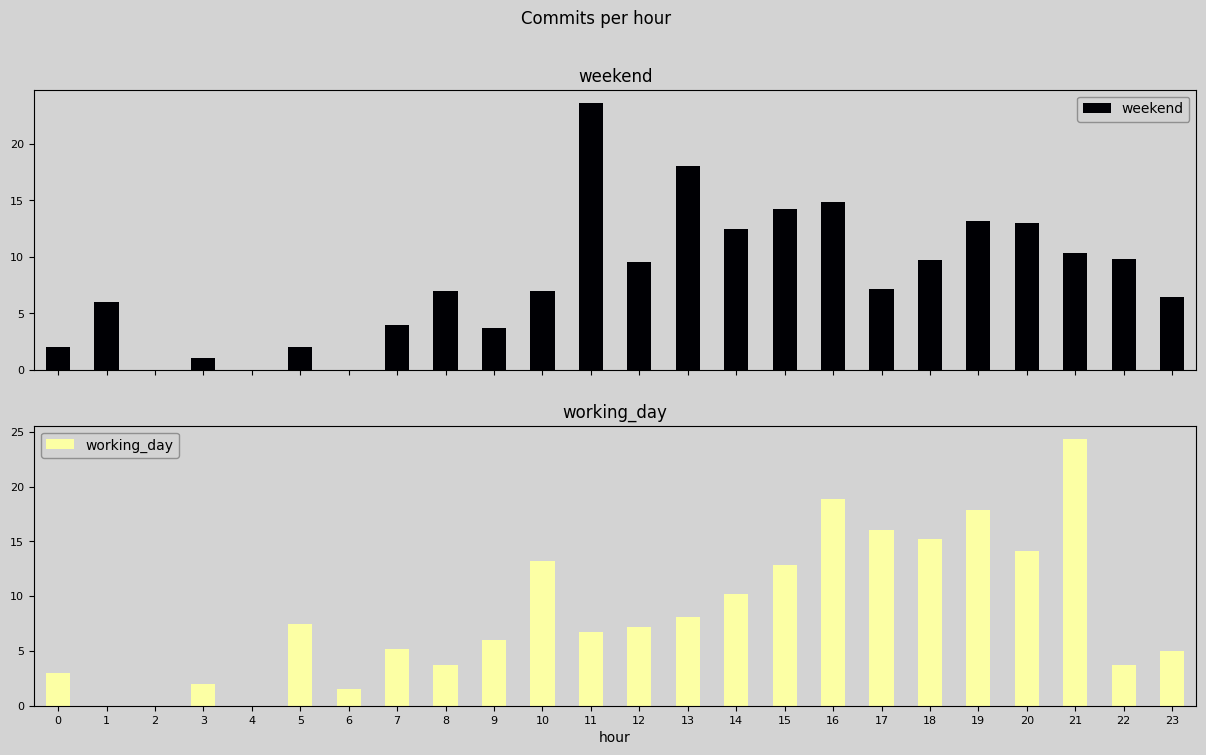

In [28]:
axes = all_hours.plot(kind = 'bar', subplots=True, layout=(2, 1), colormap='inferno',
              figsize=(15, 8), fontsize=8, title="Commits per hour")
axes[0, 0].figure.set_facecolor('lightgray')
for ax in axes.flatten():
    ax.set_facecolor('lightgray')
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('hour')
    legend = ax.get_legend()
    legend.get_frame().set_facecolor('lightgray')  # Заливаем фон легенды серым
    legend.get_frame().set_edgecolor('gray')  # Устанавливаем цвет рамки легенды

**«Отличается ли динамика в рабочие и выходные дни?»** 

Час, когда количество коммитов наибольшее в рабочие дни — 21

Час, когда количество коммитов наибольшее в выходные дни — 11

In [29]:
conn.close()